# Build a simple recommender 

A simple recommender simply requires a metric to rank all objects by (i.e. it will recommend the highest ranked objects).    

In this way, a simple recommender can be coded as a business rule and benchmarked against more advanced machine learning methods. The output from a simple recommender can still be filtered to output a more refined list for individual user types.  

## Tutorial source  
The Datacamp community tutorial [Beginner Tutorial: Recommender Systems in Python](https://www.datacamp.com/community/tutorials/recommender-systems-python) by Aditya Sharma.    

## Dataset source  
We will use a cleaned csv file of all [45,000 IMDB movies](https://www.kaggle.com/rounakbanik/the-movies-dataset/data) to try and predict the [IMDB Top 250 movies](https://www.kaggle.com/mukul1904/imdb-top-250) using our own simple recommender.   

In [1]:
# Import Python libraries ----
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import dataset as Pandas data frame ---- 
data_filepath = pathlib.Path.cwd().parent.joinpath('data',
                                                   'IMDB_all_movies',
                                                   'movies_metadata.csv') 

movie_metadata = pd.read_csv(data_filepath, low_memory = False)  

In [3]:
# View film_metadata ----
movie_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


# Step 1: Create ranking metric  

## Use a raw score 
The simplest metric for ranking movies would be by the `vote_average` score.  

Text(-9.075000000000003, 0.5, 'Number of movies')

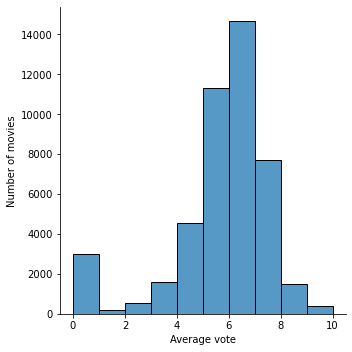

In [4]:
# Visualise vote average distribution ----
sns.displot(movie_metadata["vote_average"], bins = 10)
plt.xlabel("Average vote") 
plt.ylabel("Number of movies")

The distribution of `vote_average` is slightly negatively skewed as we would expect the majority of movies to score relatively favourably, or the movie industry would quickly bankrupt itself.   

A slight bimodal distribution also exists, where a small subset of movies are rated very poorly. This distribution could originate from voting behaviours. I.e. a mediocre movie may be voted a score between 3 and 5 compared to a terrible movie, which will be consistently voted a score of 1. Alternatively, it could reflect a real phenonmenon in the movie making industry, where some movies are deliberately created to be terrible.     

## Use a weighted score

Alternatively, a weighted metric for ranking movies would factor: 
+ A minimum threshold for the number of votes a movies needs to have.    
+ A method of weighting the film score by the number of votes (relative to each other so that movies with a higher number of votes have a higher movie score weighting).    

$$WeightedScore = (\frac{v}{v + m} \times R) + (\frac{m}{v + m} \times A)$$ 

Where:  
+ **v** is the number of votes an individual movie has.   
+ **m** is the minimum number of votes a movie needs to have to be included.    
+ **R** is the average vote of an individual movie.    
+ **C** is the average vote calculated across all included movies.    

The advantage of this weighted score is:  
+ Movies with a small number of votes will be penalised more by **m** i.e. **R** is multiplied by a smaller number.  
+ The average score of movies is used as the penalty weight, rather than the minimum score of 1. This is a more realistic penalty weight as the majority of movies score well above 1.  

The disadvantage of this weighted score is:  
+ If the threshold **m** is too low, movies with a small number of votes but a very high score will be weighted relatively more favourably than movies with an extremely high number of votes and a slightly lower score.    

In [5]:
# Test for weighted metric weaknesses ---- 
test_1 = (1000 / (1000 + 10) * 5) + (10 / (1000 + 10) * 3)
test_2 = (10000 / (10000 + 10) * 4.5) + (10 / (10000 + 10) * 3)  

test_3 = (1000 / (1000 + 1000) * 5) + (1000 / (1000 + 1000) * 3)
test_4 = (10000 / (10000 + 1000) * 4.8) + (1000 / (10000 + 1000) * 3)  

print("The impact on final weight when m = 10 is {0} versus {1}.".format(test_1, test_2))
print("The impact on final weight when m = 1000 is {0} versus {1}.".format(test_3, test_4))

The impact on final weight when m = 10 is 4.98019801980198 versus 4.498501498501499.
The impact on final weight when m = 1000 is 4.0 versus 4.636363636363636.


In this tutorial, we have decided to define **m** as the 95th percentile for `vote_count` as it is an extremely positively skewed distribution.     

In [6]:
# Find 95th percentile of vote count ---- 
counts = movie_metadata["vote_count"].to_numpy(dtype = np.int32)
m = np.percentile(counts, 95) 
m = np.round(m, decimals = 0)

print("The 95% percentile for vote_count is {0}".format(m))  

The 95% percentile for vote_count is 434.0


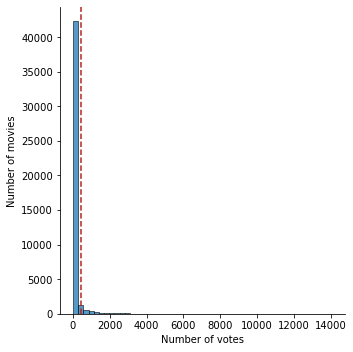

In [7]:
# Visualise vote count distribution ----
sns.displot(movie_metadata["vote_count"], bins=50)
plt.xlabel("Number of votes") 
plt.ylabel("Number of movies")
plt.axvline(x = m, ymin = 0, ymax = max(movie_metadata["vote_count"]),
            color = "firebrick", linestyle = "--")

In [8]:
# Filter movies list by vote_count > m ----  
movie_metadata_clean = movie_metadata.copy()
movie_metadata_clean = (movie_metadata.loc[movie_metadata.vote_count > m].
                       reset_index(drop = True))

                       
print(movie_metadata.shape) # 45466 movies in original dataset     
print(movie_metadata_clean.shape) # 2268 movies as selected data inputs  

(45466, 24)
(2268, 24)


**Note:** When filtering by `m`, remember to [avoid chain indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy) by appending `.loc` to the data frame.  

In [9]:
# Calculate A ----  
votes_clean = movie_metadata["vote_average"].to_numpy(dtype = np.int32)
A = np.median(votes_clean) 

print("The median for vote_count is {0}.".format(A))  

The median for vote_count is 6.0.


In [10]:
# Calculate weighted score ----  
def weighted_vote_average(df, m = m, A = A): 
    v = df["vote_count"] 
    R = df["vote_average"] 
    
    return((v / (v + m) * R ) + (m / (v + m) * A))  

movie_metadata_clean["weighted_score"] = movie_metadata_clean.apply(weighted_vote_average, axis = 1)

<AxesSubplot:xlabel='vote_average', ylabel='Count'>

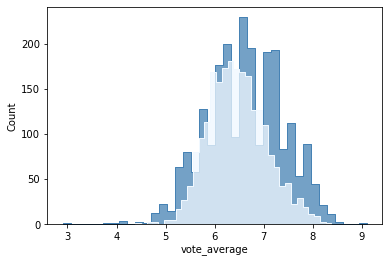

In [11]:
# Examine distribution of weighted_score versus vote_average ----  
fig, ax = plt.subplots()
sns.histplot(movie_metadata_clean["vote_average"], element = "step", color = "steelblue", ax = ax)
sns.histplot(movie_metadata_clean["weighted_score"], element = "step", color = "aliceblue", ax = ax)

# Construct recommender output

Make filterable widget

In [12]:
# View film_metadata columns ----
movie_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

# Resources  

+ A [Datacamp community tutorial](https://www.datacamp.com/community/tutorials/recommender-systems-python) covering an introduction to recommender systems for beginners.     